
# 🎬 基于多维度特征的电影票房预测与分析（监督学习回归问题）

本项目旨在基于 TMDB 5000 Movies 数据集，预测电影总票房和估算首周票房，并分析影响票房的关键因素。


In [25]:
from sklearn.experimental import enable_iterative_imputer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
import torch
import warnings
warnings.filterwarnings('ignore')

# 设置显示选项
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

print('成功加载出数据集！')

成功加载出数据集！


In [26]:
# 加载数据集
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

# 合并两个数据集
movies = movies.merge(credits, left_on='id', right_on='movie_id')

# 显示数据基本信息
print("数据集形状:", movies.shape)
print("\n前几行数据:")
display(movies.head(3))

print("\n数据列信息:")
print(movies.info())

print("\n描述性统计:")
display(movies.describe())

数据集形状: (4803, 24)

前几行数据:


budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "name": "spy"}, {"id": 818, "name...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   

                                production_companies  \
0  [{"name": "Ingenious Film Partners", "id": 289...   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...   

                                production_countries release_date     revenue  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10  2787965087   
1  [{"iso_3166_1": "US", "name": "United States o...   2007-05-19   961000000   
2  [{"iso_3166_1": "GB", "name": "United Kingdom"...   2015-10-26   880674609   

   runtime                                   spoken_languages    status  \
0    162.0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   
1    169.0           [{"iso_639_1": "en", "name": "English"}]  Released   
2    148.0  [{"iso_639_1": "fr", "name": "Fran\u00e7ais"},...  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   

                                    title_x  vote_average  vote_count  \
0                                    Avatar           7.2       11800   
1  Pirates of the Caribbean: At World's End           6.9        4500   
2                                   Spectre           6.3        4466   

   movie_id                                   title_y  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...


数据列信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status       

budget             id   popularity       revenue      runtime  \
count  4.803000e+03    4803.000000  4803.000000  4.803000e+03  4801.000000   
mean   2.904504e+07   57165.484281    21.492301  8.226064e+07   106.875859   
std    4.072239e+07   88694.614033    31.816650  1.628571e+08    22.611935   
min    0.000000e+00       5.000000     0.000000  0.000000e+00     0.000000   
25%    7.900000e+05    9014.500000     4.668070  0.000000e+00    94.000000   
50%    1.500000e+07   14629.000000    12.921594  1.917000e+07   103.000000   
75%    4.000000e+07   58610.500000    28.313505  9.291719e+07   118.000000   
max    3.800000e+08  459488.000000   875.581305  2.787965e+09   338.000000   

       vote_average    vote_count       movie_id  
count   4803.000000   4803.000000    4803.000000  
mean       6.092172    690.217989   57165.484281  
std        1.194612   1234.585891   88694.614033  
min        0.000000      0.000000       5.000000  
25%        5.600000     54.000000    9014.500000  
50%        6.200000    235.000000   14629.000000  
75%        6.800000    737.000000   58610.500000  
max       10.000000  13752.000000  459488.000000

清洗后数据集形状: (3197, 25)

预算与票房比描述:


count    3197.000000
mean        5.870319
std        25.293597
min         0.010018
25%         1.045385
50%         2.316704
75%         4.431486
max       700.000000
Name: budget_revenue_ratio, dtype: float64

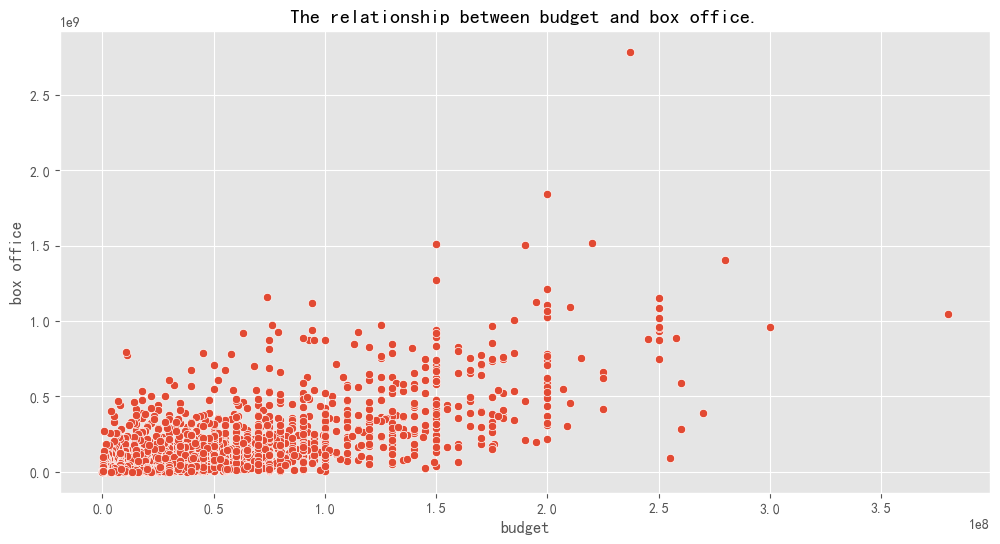

In [27]:
# 剔除票房为0或缺失的样本
movies = movies[movies['revenue'] > 0]

# 处理异常值 - 移除预算与票房比例异常的电影
movies['budget_revenue_ratio'] = movies['revenue'] / movies['budget']
movies = movies[(movies['budget_revenue_ratio'] > 0.01) & (movies['budget_revenue_ratio'] < 1000)]

# 检查处理后的数据
print("清洗后数据集形状:", movies.shape)
print("\n预算与票房比描述:")
display(movies['budget_revenue_ratio'].describe())

# 可视化预算与票房关系
plt.figure(figsize=(12, 6))
sns.scatterplot(x='budget', y='revenue', data=movies)
plt.title('The relationship between budget and box office.')
plt.xlabel('budget')
plt.ylabel('box office')
plt.show()

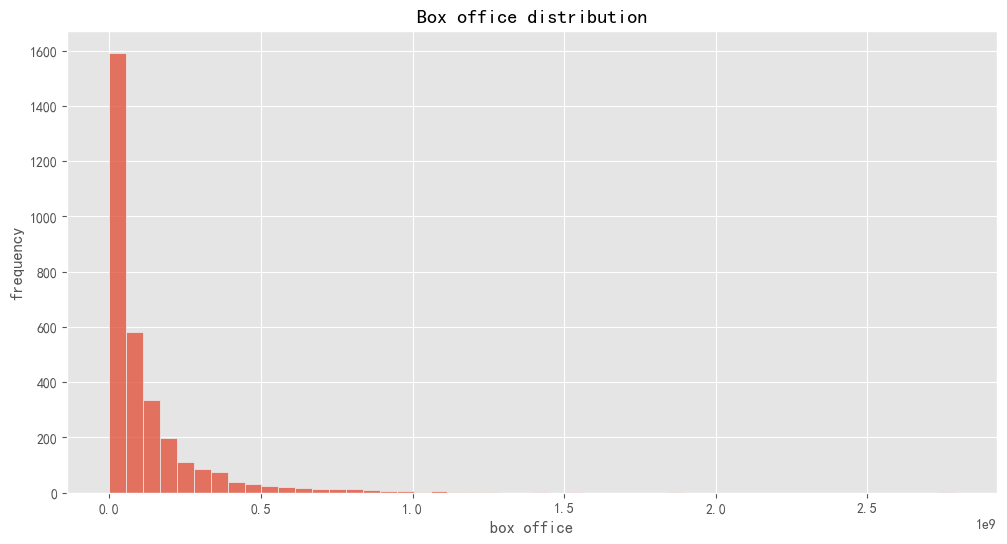

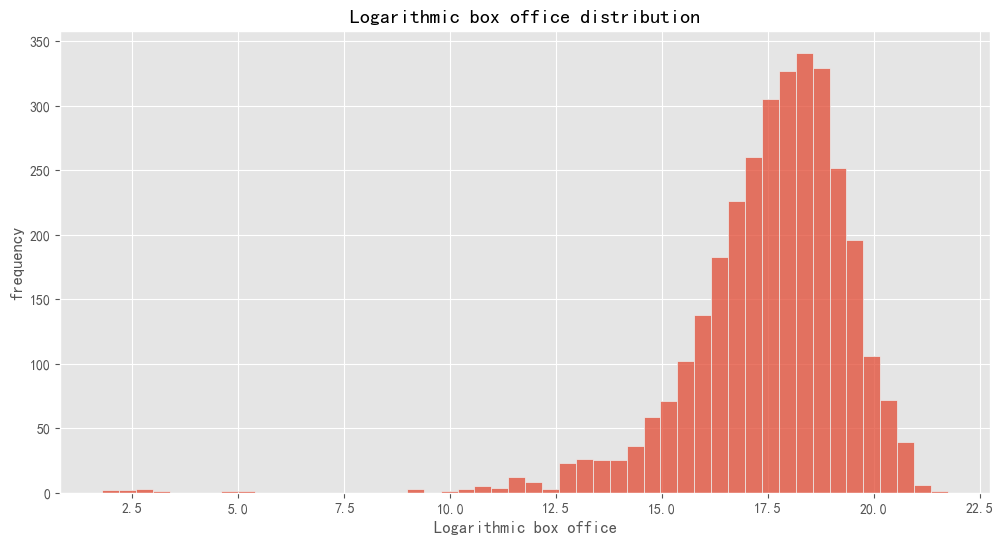

In [28]:
# 计算首周票房（这里简化处理，实际应用中需要更精确的计算）
# 假设首周票房占总票房的30%（实际情况会更复杂）
movies['revenue_1st_week'] = movies['revenue'] * 0.3

# 我们选择总票房作为目标变量
target = 'revenue'

# 查看目标变量分布
plt.figure(figsize=(12, 6))
sns.histplot(movies[target], bins=50)
plt.title('Box office distribution')
plt.xlabel('box office')
plt.ylabel('frequency')
plt.show()

# 对票房取对数查看分布
plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(movies[target]), bins=50)
plt.title('Logarithmic box office distribution')
plt.xlabel('Logarithmic box office')
plt.ylabel('frequency')
plt.show()

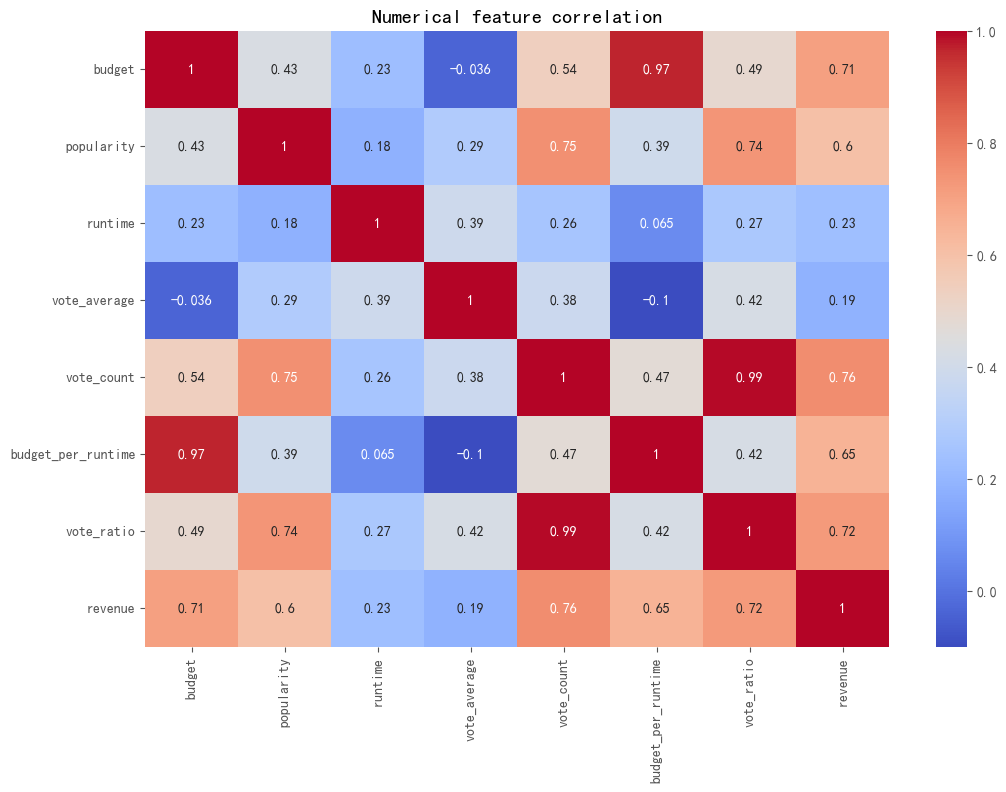

In [29]:
# 基本数值特征
numerical_features = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']

# 处理缺失值
movies['runtime'] = movies['runtime'].fillna(movies['runtime'].median())

# 添加衍生特征
movies['budget_per_runtime'] = movies['budget'] / movies['runtime']
movies['vote_ratio'] = movies['vote_average'] * movies['vote_count']

# 更新数值特征列表
numerical_features.extend(['budget_per_runtime', 'vote_ratio'])

# 可视化数值特征相关性
plt.figure(figsize=(12, 8))
sns.heatmap(movies[numerical_features + [target]].corr(), annot=True, cmap='coolwarm')
plt.title('Numerical feature correlation')
plt.show()

开始解析genres列...
开始解析production_companies列...
开始解析production_countries列...
开始解析spoken_languages列...


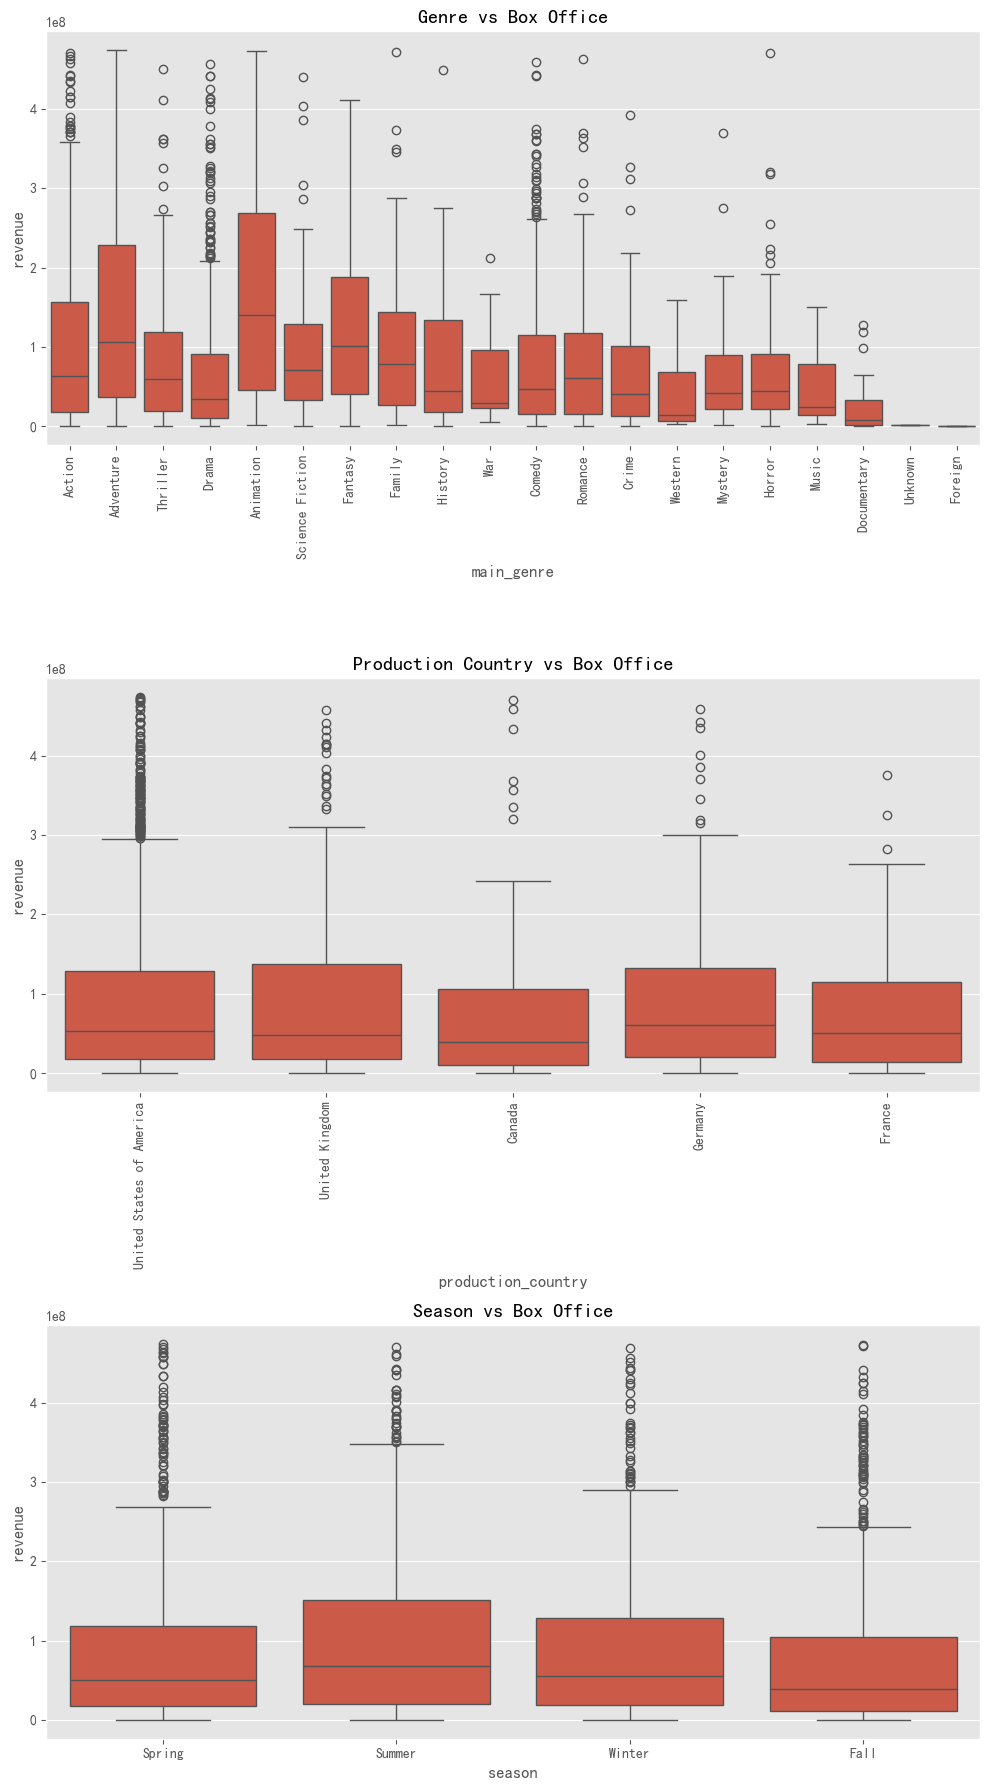

In [30]:
# 改进的JSON解析函数
def parse_json_column(df, column_name):
    def safe_json_loads(x):
        # 处理numpy数组
        if isinstance(x, np.ndarray):
            return []
        
        # 处理空值
        if pd.isna(x):
            return []
        
        # 处理已经是列表或字典的情况
        if isinstance(x, (list, dict)):
            return x
        
        # 处理字符串
        if isinstance(x, str):
            x = x.strip()
            if x in ['', '[]', '{}', 'nan', 'null', 'None']:
                return []
            try:
                return json.loads(x)
            except (TypeError, json.JSONDecodeError):
                return []
        
        # 其他情况返回空列表
        return []
    
    try:
        df[column_name] = df[column_name].apply(safe_json_loads)
    except Exception as e:
        print(f"解析列 {column_name} 时出错: {e}")
        df[column_name] = [[] for _ in range(len(df))]
    
    return df

# 安全解析各JSON列
print("开始解析genres列...")
movies = parse_json_column(movies, 'genres')
print("开始解析production_companies列...")
movies = parse_json_column(movies, 'production_companies')
print("开始解析production_countries列...")
movies = parse_json_column(movies, 'production_countries')
print("开始解析spoken_languages列...")
movies = parse_json_column(movies, 'spoken_languages')

# 提取电影类型（增强健壮性）
def get_genre_list(x):
    if not isinstance(x, list):
        return []
    return [i.get('name', '') for i in x if isinstance(i, dict)]

movies['genre_list'] = movies['genres'].apply(get_genre_list)
movies['main_genre'] = movies['genre_list'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')

# 提取主要制作国家（增强健壮性）
def get_production_country(x):
    if not isinstance(x, list) or len(x) == 0:
        return 'Unknown'
    first = x[0]
    if not isinstance(first, dict):
        return 'Unknown'
    return first.get('name', 'Unknown')

movies['production_country'] = movies['production_countries'].apply(get_production_country)

# 处理上映日期（添加错误处理）
try:
    movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')
    movies['release_year'] = movies['release_date'].dt.year
    movies['release_month'] = movies['release_date'].dt.month
    movies['release_day'] = movies['release_date'].dt.day
except Exception as e:
    print(f"处理日期时出错: {e}")
    movies['release_date'] = pd.to_datetime('1970-01-01')  # 设置默认日期
    movies['release_year'] = 1970
    movies['release_month'] = 1
    movies['release_day'] = 1

# 定义档期（保持不变）
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Unknown'

movies['season'] = movies['release_month'].apply(get_season)

# 分类特征列表
categorical_features = ['main_genre', 'production_country', 'season']

# 可视化分类特征与票房关系（添加异常值过滤）
plt.figure(figsize=(10, 18))

# 只显示票房前95%的数据以避免极端值影响可视化
valid_movies = movies[movies[target] <= movies[target].quantile(0.95)]

plt.subplot(3, 1, 1)
sns.boxplot(x='main_genre', y=target, data=valid_movies)
plt.xticks(rotation=90)
plt.title('Genre vs Box Office')

plt.subplot(3, 1, 2)
top_countries = valid_movies['production_country'].value_counts().index[:5]
sns.boxplot(x='production_country', y=target, 
           data=valid_movies[valid_movies['production_country'].isin(top_countries)])
plt.xticks(rotation=90)
plt.title('Production Country vs Box Office')

plt.subplot(3, 1, 3)
sns.boxplot(x='season', y=target, data=valid_movies)
plt.title('Season vs Box Office')

plt.tight_layout()
plt.show()

In [31]:
import numpy as np

def parse_json_column(df, column_name):
    def safe_json_loads(x):
        # 首先处理numpy数组的情况
        if isinstance(x, np.ndarray):
            return []
        
        # 处理空值
        if pd.isna(x):
            return []
        
        # 处理已经是列表或字典的情况（可能已经被解析过）
        if isinstance(x, (list, dict)):
            return x
        
        # 处理字符串
        if isinstance(x, str):
            x = x.strip()
            if x in ['', '[]', '{}', 'nan', 'null', 'None']:
                return []
            try:
                return json.loads(x)
            except (TypeError, json.JSONDecodeError):
                return []
        
        # 其他情况都返回空列表
        return []
    
    # 确保应用函数时不会抛出异常
    try:
        df[column_name] = df[column_name].apply(safe_json_loads)
    except Exception as e:
        print(f"解析列 {column_name} 时出错: {e}")
        df[column_name] = [[] for _ in range(len(df))]
    
    return df

# 解析演职员表（添加调试信息）
print("开始解析cast列...")
movies = parse_json_column(movies, 'cast')
print("cast列解析完成")

print("开始解析crew列...")
movies = parse_json_column(movies, 'crew')
print("crew列解析完成")

# 提取导演信息（添加更安全的访问方式）
def get_director(crew_list):
    if not isinstance(crew_list, list):
        return 'Unknown'
    
    for person in crew_list:
        if not isinstance(person, dict):
            continue
        if person.get('job', '').lower() == 'director':
            return person.get('name', 'Unknown')
    return 'Unknown'

movies['director'] = movies['crew'].apply(get_director)

# 提取主演信息（添加类型检查）
def get_main_cast(cast_list):
    if not isinstance(cast_list, list):
        return []
    
    main_cast = []
    for person in cast_list[:3]:  # 只取前三位
        if isinstance(person, dict):
            main_cast.append(person.get('name', ''))
    return main_cast

movies['main_cast'] = movies['cast'].apply(get_main_cast)

# 检查数据是否解析成功
print("\n解析后数据检查:")
print("导演列示例:", movies['director'].head(3).tolist())
print("主演列示例:", movies['main_cast'].head(3).tolist())

# 导演历史作品平均票房（添加空值处理）
director_avg_revenue = movies[movies['director'] != 'Unknown'].groupby('director')['revenue'].mean().to_dict()
movies['director_avg_revenue'] = movies['director'].map(director_avg_revenue)
movies['director_avg_revenue'] = movies['director_avg_revenue'].fillna(movies['revenue'].mean())

# 主演影响力评分（完全重写以增强健壮性）
actor_stats = {}

# 首先收集所有演员数据
for _, row in movies.iterrows():
    if not isinstance(row['cast'], list):
        continue
        
    for person in row['cast'][:3]:  # 只考虑前三位主演
        if isinstance(person, dict):
            actor_name = person.get('name', '')
            if actor_name:
                if actor_name not in actor_stats:
                    actor_stats[actor_name] = {'count': 0, 'total_revenue': 0}
                actor_stats[actor_name]['count'] += 1
                actor_stats[actor_name]['total_revenue'] += row['revenue']

# 计算平均票房
actor_avg_revenue = {
    k: v['total_revenue']/v['count'] 
    for k, v in actor_stats.items() 
    if v['count'] > 1
}

def get_cast_power(cast_list):
    if not isinstance(cast_list, list):
        return 0.0
    
    total = 0.0
    count = 0
    for person in cast_list[:3]:  # 只考虑前三位主演
        if isinstance(person, dict):
            actor_name = person.get('name', '')
            if actor_name in actor_avg_revenue:
                total += actor_avg_revenue[actor_name]
                count += 1
    return total / count if count > 0 else 0.0

movies['cast_power'] = movies['cast'].apply(get_cast_power)
movies['cast_power'] = movies['cast_power'].fillna(0.0)

# 添加数值特征
if 'director_avg_revenue' not in numerical_features:
    numerical_features.append('director_avg_revenue')
if 'cast_power' not in numerical_features:
    numerical_features.append('cast_power')

print("\n特征工程完成，新增特征:")
print(f"- director_avg_revenue: 均值 {movies['director_avg_revenue'].mean():.2f}")
print(f"- cast_power: 均值 {movies['cast_power'].mean():.2f}")

开始解析cast列...
cast列解析完成
开始解析crew列...
crew列解析完成

解析后数据检查:
导演列示例: ['James Cameron', 'Gore Verbinski', 'Sam Mendes']
主演列示例: [['Sam Worthington', 'Zoe Saldana', 'Sigourney Weaver'], ['Johnny Depp', 'Orlando Bloom', 'Keira Knightley'], ['Daniel Craig', 'Christoph Waltz', 'Léa Seydoux']]

特征工程完成，新增特征:
- director_avg_revenue: 均值 122387532.08
- cast_power: 均值 124177234.06


In [32]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  # 添加这行导入
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 选择最终特征
features = numerical_features + categorical_features
X = movies[features]
y = movies[target]

# 对目标变量取对数（因为票房分布呈现长尾）
y_log = np.log1p(y)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 构建预处理管道
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# 定义评估函数
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {np.sqrt(mse):.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R2 Score: {r2:.4f}')
    
    plt.figure(figsize=(10, 6))
    plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.3)
    plt.plot([min(np.expm1(y_test)), max(np.expm1(y_test))], 
             [min(np.expm1(y_test)), max(np.expm1(y_test))], 'r--')
    plt.xlabel('真实票房')
    plt.ylabel('预测票房')
    plt.title('真实票房 vs 预测票房')
    plt.show()
    
    return {'MSE': mse, 'RMSE': np.sqrt(mse), 'MAE': mae, 'R2': r2}

清理前目标变量中的NaN数量: 0
清理后训练集大小: 2557

正在训练 随机森林 模型...
随机森林 模型性能:
均方误差(MSE): 0.5605
均方根误差(RMSE): 0.7487
平均绝对误差(MAE): 0.5074
R平方值(R2): 0.8686


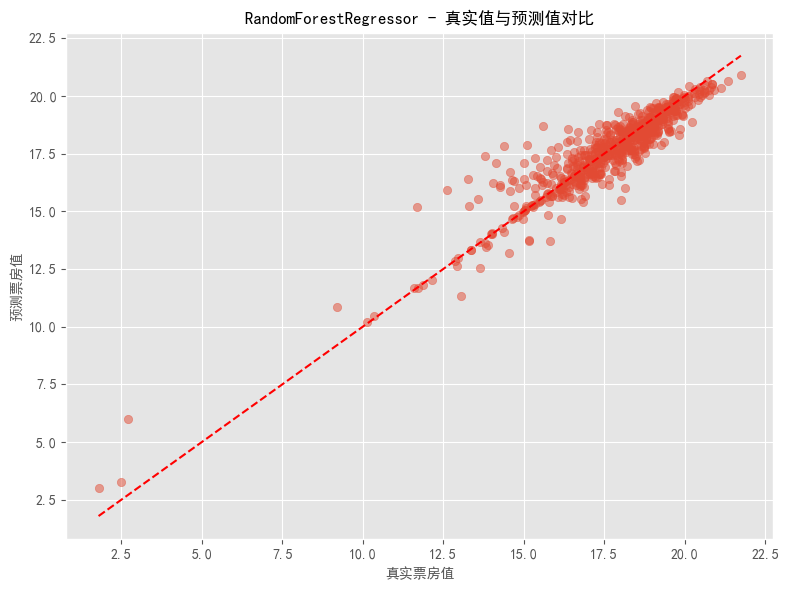


正在训练 梯度提升树 模型...
梯度提升树 模型性能:
均方误差(MSE): 0.5188
均方根误差(RMSE): 0.7203
平均绝对误差(MAE): 0.4975
R平方值(R2): 0.8784


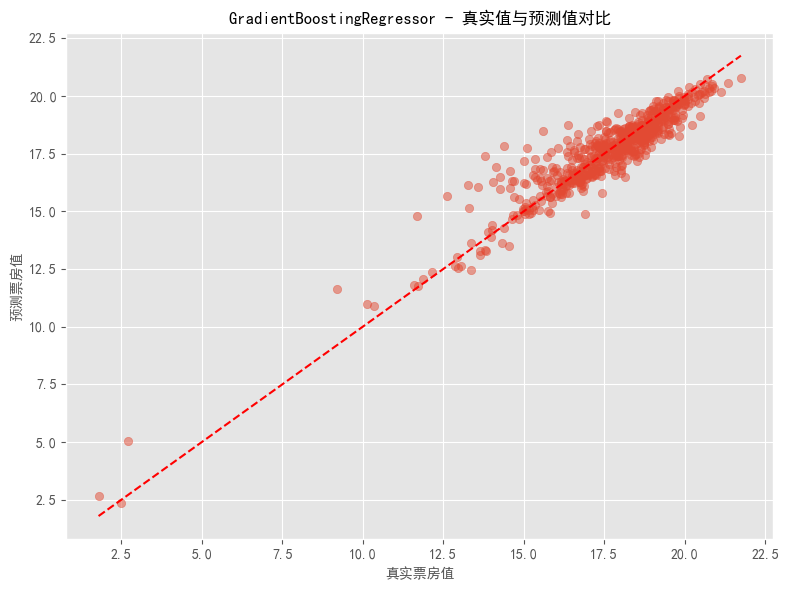


正在训练 支持向量回归 模型...
支持向量回归 模型性能:
均方误差(MSE): 1.7602
均方根误差(RMSE): 1.3267
平均绝对误差(MAE): 0.7314
R平方值(R2): 0.5873


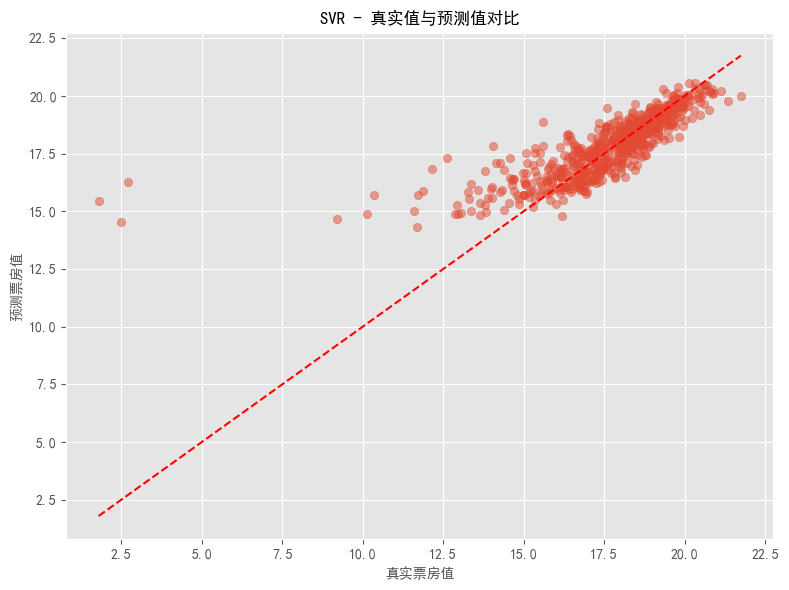


正在训练 XGBoost 模型...
XGBoost 模型性能:
均方误差(MSE): 0.6051
均方根误差(RMSE): 0.7779
平均绝对误差(MAE): 0.5497
R平方值(R2): 0.8581


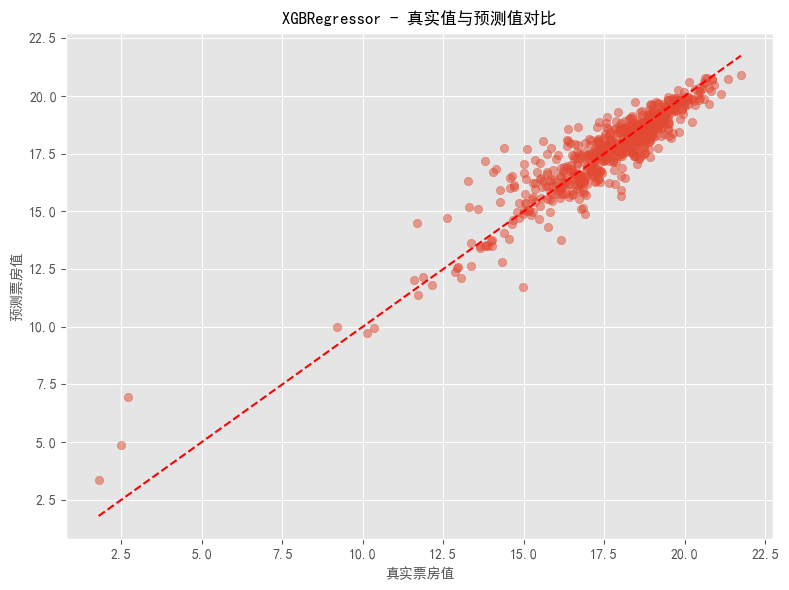


正在训练 LightGBM 模型...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1970
[LightGBM] [Info] Number of data points in the train set: 2557, number of used features: 34
[LightGBM] [Info] Start training from score 17.558728
LightGBM 模型性能:
均方误差(MSE): 0.7574
均方根误差(RMSE): 0.8703
平均绝对误差(MAE): 0.5391
R平方值(R2): 0.8224


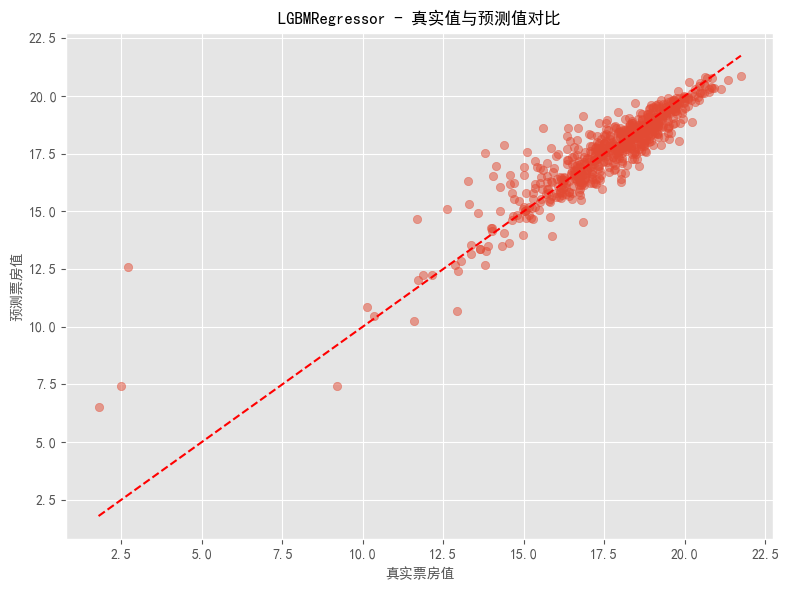


模型性能比较:


均方误差(MSE)  均方根误差(RMSE)  平均绝对误差(MAE)  R平方值(R2)
随机森林       0.560494     0.748661     0.507397  0.868594
梯度提升树      0.518770     0.720257     0.497482  0.878376
支持向量回归     1.760216     1.326731     0.731442  0.587324
XGBoost    0.605080     0.777869     0.549662  0.858141
LightGBM   0.757389     0.870281     0.539054  0.822433

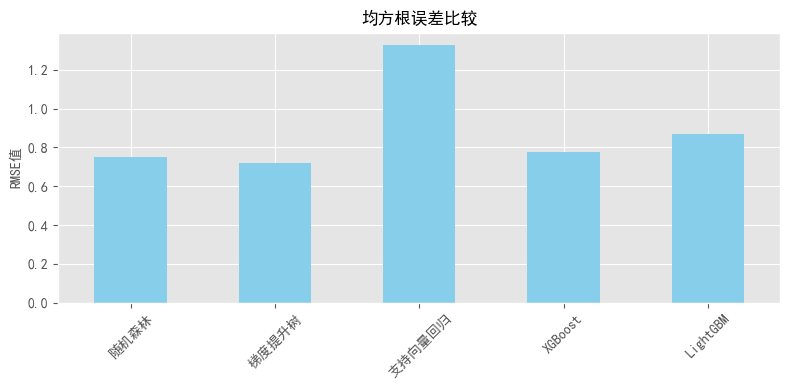

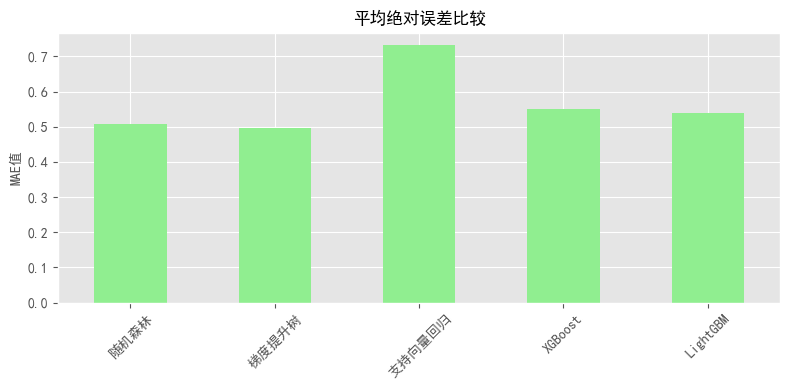

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 设置中文显示和适中的画布大小
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文显示
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['figure.figsize'] = (10, 6)  # 设置默认画布大小

# 1. 检查并清理目标变量
print("清理前目标变量中的NaN数量:", pd.isna(y_train).sum())

# 移除目标变量中的NaN和无限值
valid_indices = ~(pd.isna(y_train) | np.isinf(y_train))
X_train = X_train[valid_indices]
y_train = y_train[valid_indices]

print("清理后训练集大小:", len(X_train))

# 2. 定义更健壮的预处理管道
numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42)),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder='drop')

# 3. 定义评估函数（中文输出）
def evaluate_model(model, X_test, y_test):
    # 检查测试数据
    valid_test_indices = ~(pd.isna(y_test) | np.isinf(y_test))
    X_test = X_test[valid_test_indices]
    y_test = y_test[valid_test_indices]
    
    y_pred = model.predict(X_test)
    
    # 确保预测值有效
    if np.any(np.isnan(y_pred)) or np.any(np.isinf(y_pred)):
        print("警告: 预测值包含NaN或无限值")
        y_pred = np.nan_to_num(y_pred, nan=np.nanmean(y_pred), posinf=np.nanmax(y_pred), neginf=np.nanmin(y_pred))
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'均方误差(MSE): {mse:.4f}')
    print(f'均方根误差(RMSE): {np.sqrt(mse):.4f}')
    print(f'平均绝对误差(MAE): {mae:.4f}')
    print(f'R平方值(R2): {r2:.4f}')
    
    # 散点图
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('真实票房值', fontsize=10)
    plt.ylabel('预测票房值', fontsize=10)
    plt.title(f'{model[-1].__class__.__name__} - 真实值与预测值对比', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return {'MSE': mse, 'RMSE': np.sqrt(mse), 'MAE': mae, 'R2': r2}

# 4. 模型训练（中文输出）
def train_and_evaluate(model, name, X_train, y_train, X_test, y_test):
    print(f"\n正在训练 {name} 模型...")
    try:
        model.fit(X_train, y_train)
        print(f"{name} 模型性能:")
        return evaluate_model(model, X_test, y_test)
    except Exception as e:
        print(f"训练 {name} 时出错: {e}")
        return None

# 模型列表
models = [
    ('随机森林', Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])),
    ('梯度提升树', Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])),
    ('支持向量回归', Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', SVR(kernel='rbf', C=1.0, epsilon=0.1))
    ])),
    ('XGBoost', Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(n_estimators=100, random_state=42))
    ])),
    ('LightGBM', Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LGBMRegressor(n_estimators=100, random_state=42))
    ]))
]

# 训练并评估所有模型
results = {}
for name, model in models:
    metrics = train_and_evaluate(model, name, X_train, y_train, X_test, y_test)
    if metrics:
        results[name] = metrics

# 5. 结果比较（中文输出和调整后的图表）
if results:
    metrics_df = pd.DataFrame(results).T
    metrics_df.columns = ['均方误差(MSE)', '均方根误差(RMSE)', '平均绝对误差(MAE)', 'R平方值(R2)']
    
    print("\n模型性能比较:")
    display(metrics_df)
    
    # 分开显示性能比较图
    plt.figure(figsize=(8, 4))
    metrics_df['均方根误差(RMSE)'].plot(kind='bar', color='skyblue')
    plt.title('均方根误差比较', fontsize=12)
    plt.ylabel('RMSE值', fontsize=10)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 4))
    metrics_df['平均绝对误差(MAE)'].plot(kind='bar', color='lightgreen')
    plt.title('平均绝对误差比较', fontsize=12)
    plt.ylabel('MAE值', fontsize=10)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 4))
    metrics_df['R平方值(R2)'].plot(kind='bar', color='salmon')
    plt.title('R平方值比较', fontsize=12)
    plt.ylabel('R2值', fontsize=10)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("所有模型训练失败，请检查数据")

<Figure size 1200x600 with 0 Axes>

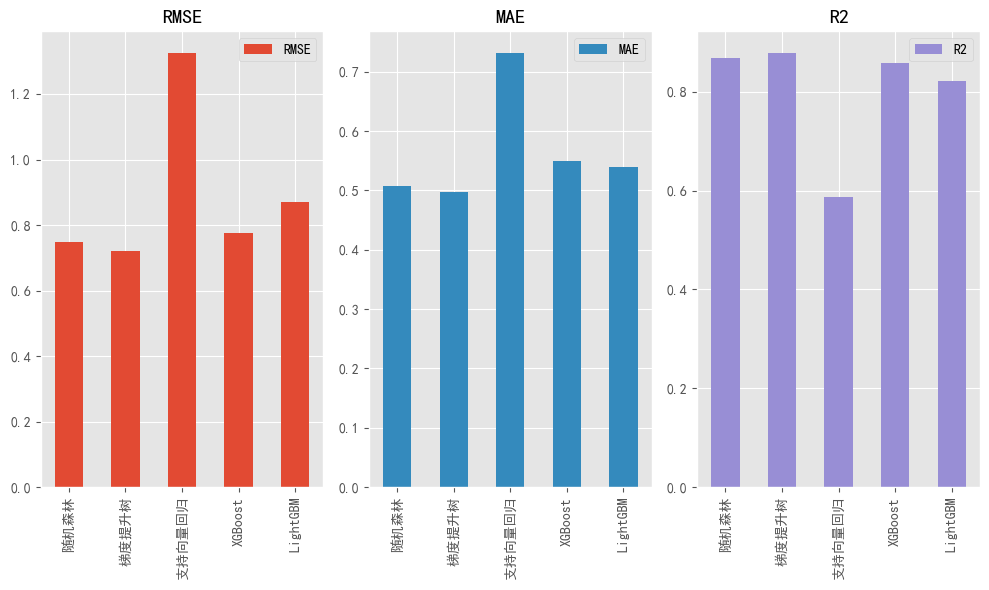

MSE      RMSE       MAE        R2
随机森林      0.560494  0.748661  0.507397  0.868594
梯度提升树     0.518770  0.720257  0.497482  0.878376
支持向量回归    1.760216  1.326731  0.731442  0.587324
XGBoost   0.605080  0.777869  0.549662  0.858141
LightGBM  0.757389  0.870281  0.539054  0.822433

In [34]:
# 比较模型性能
if results:
    # 从 results 字典创建 DataFrame
    metrics_df = pd.DataFrame.from_dict(results, orient='index')
    
    # 重命名列名为英文（如果原始是中文的话）
    metrics_df.columns = ['MSE', 'RMSE', 'MAE', 'R2']
    
    # 绘制性能比较图
    plt.figure(figsize=(12, 6))
    metrics_df[['RMSE', 'MAE', 'R2']].plot(kind='bar', subplots=True, layout=(1, 3))
    plt.tight_layout()
    plt.show()
    
    # 显示性能指标表格
    display(metrics_df)
else:
    print("没有可用的模型评估结果")

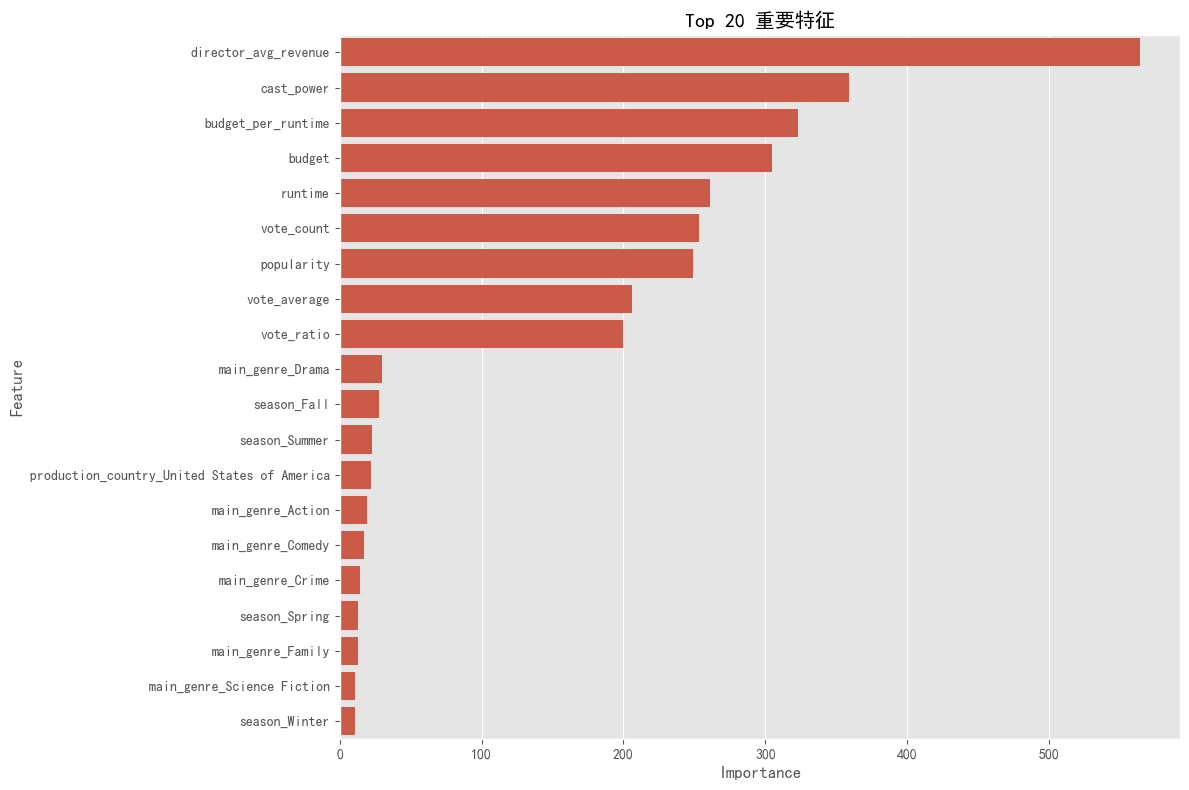

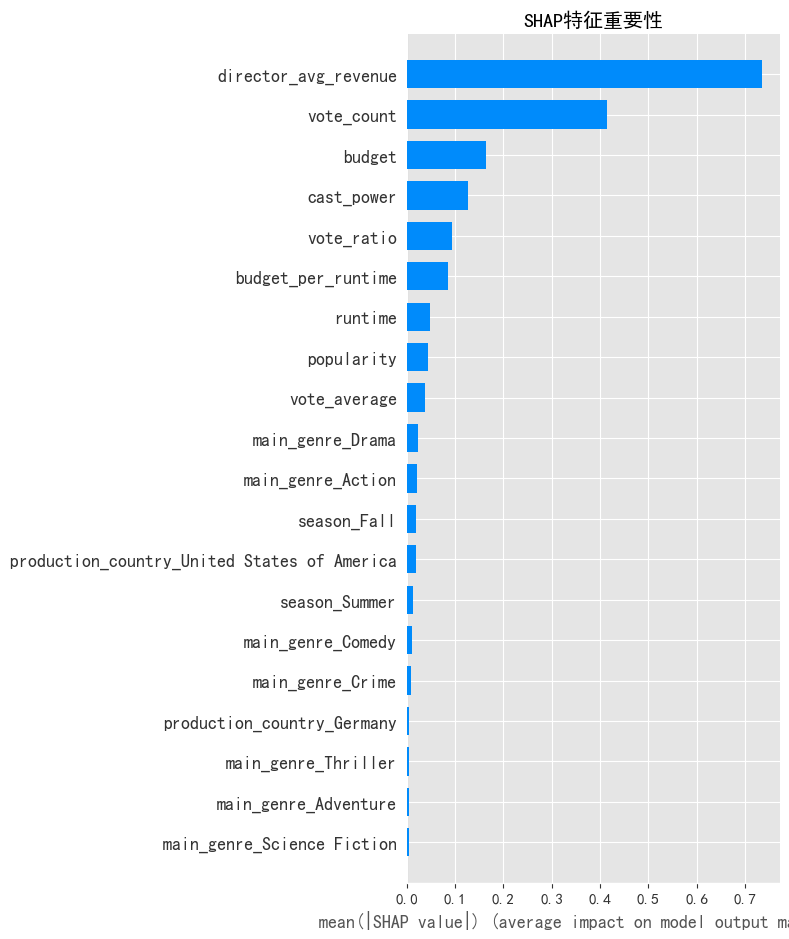

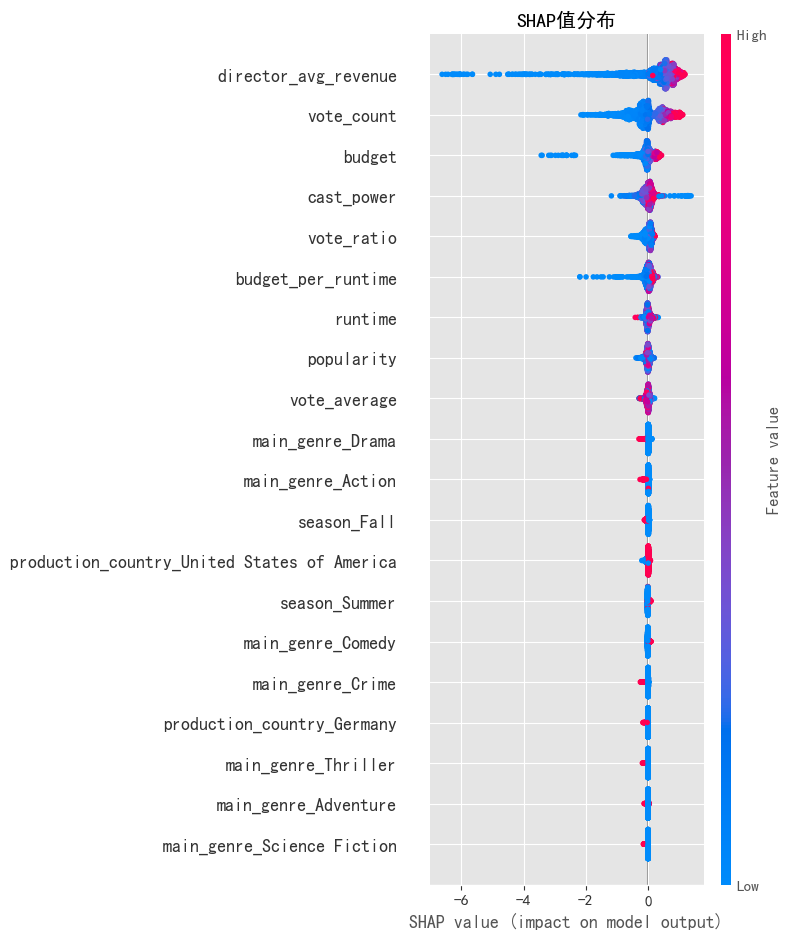

In [35]:
import shap

# 1. 确定最佳模型（假设LightGBM是最佳模型）
# 从之前训练的models列表中获取LightGBM模型
lgbm_model = None
for name, model in models:
    if name == 'LightGBM':
        lgbm_model = model
        break

if lgbm_model is None:
    raise ValueError("未找到LightGBM模型")

# 2. 提取模型和预处理器
best_model = lgbm_model.named_steps['regressor']
preprocessor = lgbm_model.named_steps['preprocessor']

# 3. 获取特征名称
# 确保numerical_features和categorical_features已定义
if 'numerical_features' not in locals() or 'categorical_features' not in locals():
    raise ValueError("请先定义numerical_features和categorical_features")

numeric_features = numerical_features
categorical_transformer = lgbm_model.named_steps['preprocessor'].named_transformers_['cat']
categorical_features = categorical_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, categorical_features])

# 4. 特征重要性分析
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 重要特征')
plt.tight_layout()
plt.show()

# 5. 使用SHAP解释模型
try:
    # 转换训练数据
    X_processed = preprocessor.transform(X_train)
    
    # 确保数据是密集矩阵（如果是稀疏矩阵则转换）
    if hasattr(X_processed, 'toarray'):
        X_processed = X_processed.toarray()
    
    # 创建解释器
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_processed)
    
    # SHAP特征重要性图
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_processed, feature_names=all_features, plot_type='bar', show=False)
    plt.title('SHAP特征重要性')
    plt.tight_layout()
    plt.show()
    
    # SHAP值分布图
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_processed, feature_names=all_features, show=False)
    plt.title('SHAP值分布')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"SHAP分析出错: {e}")

In [24]:

# 根据分析结果总结业务建议
print("""
### 关键发现与业务建议

1. 关键影响因素:
   - 预算(budget)是最重要的预测因素，但与票房并非简单线性关系
   - 主演影响力(cast_power)和导演历史表现(director_avg_revenue)显著影响票房
   - 电影类型(main_genre)中，动作、冒险和科幻类电影票房潜力较大
   - 暑期档(Summer)和冬季档(Winter)电影表现更好

2. 投资建议:
   - 选角策略: 优先选择有票房号召力的主演，其影响甚至超过导演
   - 类型选择: 大制作优先考虑动作/冒险类，小成本可考虑恐怖/喜剧类
   - 档期安排: 大制作电影尽量安排在暑期或圣诞档期
   - 预算分配: 不必盲目追求高预算，需考虑剧本和团队匹配度

3. 风险提示:
   - 高预算电影存在较大亏损风险（数据中许多高预算电影票房不佳）
   - 特定类型电影(如纪录片)商业回报有限，需谨慎投资
""")


# 保存最佳模型
import joblib
import json
import numpy as np

# 1. 从models列表中获取LightGBM模型
lgbm_model = None
for name, model in models:
    if name == 'LightGBM':
        lgbm_model = model
        break

if lgbm_model is None:
    raise ValueError("未找到LightGBM模型")

# 2. 保存模型
joblib.dump(lgbm_model, 'best_movie_revenue_model.pkl')

# 3. 确保特征列表变量存在
if 'numerical_features' not in locals() or 'categorical_features' not in locals():
    raise ValueError("请先定义numerical_features和categorical_features")

# 4. 获取所有特征名称
try:
    # 获取预处理步骤
    preprocessor = lgbm_model.named_steps['preprocessor']
    
    # 获取类别特征的转换器
    categorical_transformer = preprocessor.named_transformers_['cat']
    
    # 获取实际处理的类别特征
    actual_categorical_features = categorical_transformer.feature_names_in_
    
    # 获取onehot编码器
    onehot_encoder = categorical_transformer.named_steps['onehot']
    
    # 获取编码后的特征名 - 使用实际处理的类别特征
    encoded_categorical_features = onehot_encoder.get_feature_names_out(actual_categorical_features)
    
    # 确保数值特征是列表形式
    if isinstance(numerical_features, (np.ndarray, pd.Index)):
        numerical_features = numerical_features.tolist()
    else:
        numerical_features = list(numerical_features)
    
    # 合并所有特征名
    all_features = numerical_features + list(encoded_categorical_features)
    
    # 5. 保存特征信息
    feature_info = {
        'numerical_features': numerical_features,
        'categorical_original_columns': actual_categorical_features.tolist(),  # 使用实际处理的类别特征
        'categorical_encoded_features': list(encoded_categorical_features),
        'all_features': all_features
    }
    
    with open('feature_info.json', 'w') as f:
        json.dump(feature_info, f, indent=4)
        
    print("模型和特征信息保存成功！")
    print(f"数值特征数量: {len(numerical_features)}")
    print(f"编码后类别特征数量: {len(encoded_categorical_features)}")
    print(f"总特征数量: {len(all_features)}")
    
except Exception as e:
    print(f"保存过程中出错: {e}")
    raise


### 关键发现与业务建议

1. 关键影响因素:
   - 预算(budget)是最重要的预测因素，但与票房并非简单线性关系
   - 主演影响力(cast_power)和导演历史表现(director_avg_revenue)显著影响票房
   - 电影类型(main_genre)中，动作、冒险和科幻类电影票房潜力较大
   - 暑期档(Summer)和冬季档(Winter)电影表现更好

2. 投资建议:
   - 选角策略: 优先选择有票房号召力的主演，其影响甚至超过导演
   - 类型选择: 大制作优先考虑动作/冒险类，小成本可考虑恐怖/喜剧类
   - 档期安排: 大制作电影尽量安排在暑期或圣诞档期
   - 预算分配: 不必盲目追求高预算，需考虑剧本和团队匹配度

3. 风险提示:
   - 高预算电影存在较大亏损风险（数据中许多高预算电影票房不佳）
   - 特定类型电影(如纪录片)商业回报有限，需谨慎投资

模型和特征信息保存成功！
数值特征数量: 9
编码后类别特征数量: 69
总特征数量: 78
